## Identificación de tópicos
## Elaborado por TreeData
## Versión Mayo 5 de 2022

In [1]:
# Instalación de módulos necesarios
%load_ext autoreload
%autoreload 2
from read_files import *
#import os
#import re
import numpy as np
from nltk.corpus import stopwords
import pandas as pd
#import spacy
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer
#from pdfminer.high_level import extract_text
#from deep_translator import GoogleTranslator
import matplotlib.pyplot as plt 
import gensim
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
import tqdm
#warnings.filterwarnings("ignore",category=DeprecationWarning)
#Modulo para realizar la nuebe de palabras
from wordcloud import WordCloud

/home/wilmar3752/anaconda3/envs/nlp/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


## Lectura de datos

A continuación tendremos las siguientes funciones claves:

**get_pdf**: Esta función lee los archivos en formato pdf, quita simbolos de páginas web y otros simbolos.

**get_txt**: Esta función lee los archivos en formato txt.

**text_to_eng**: Esta función traduce los documentos del idioma español al inglés. Si desea realizar cambios en el idioma cambie en la función source='es'y target='en' (source es el idioma del documento y target es el idioma al cual se va a traducir) por los correspondientes idiomas. 

**clean_tokenize**: Esta función toma cada documento y le realiza los siguientes procesamientos:

-Convertir en minusculas el texto  
-Eliminar paginas web, signos de puntuación y espacios en blanco  
-Tokenizar el texto  
-Eliminar Stop Words (Si identifica nuevas Stop Words las debe agregar en el archivo 'stop_words.csv') 
-Lematizacion  

Estos resultados estan sujetos al rendimiento de la libreria NLTK, la cual es de las mas potentes para procesamiento de lenguaje natural.

In [3]:
data = get_data("data/files/")

español
procesando 2021-10-20 Política CTI 2022 - 2031_VDiscusión pública.pdf
..traduciendo
procesado el texto!
procesando 3527-Competitividad-y-Productividad.pdf
..traduciendo
procesado el texto!
procesando 4069.pdf
..traduciendo
procesado el texto!
procesando compes 3582.pdf
..traduciendo
procesado el texto!
procesando compes 3866.pdf
..traduciendo
procesado el texto!
procesando CPC_INC_2020_2021_Ciencia-tecnologia.pdf
..traduciendo
procesado el texto!
procesando P.L.008-2017C_004-2017S (INNOVACION AGROPECUARIA).pdf
..traduciendo
procesado el texto!
procesando pectia-2017-actualizado.pdf
..traduciendo
procesado el texto!
procesando PLAN_DE_ACCION_INSTITUCIONAL_VIGENCIA_2021.pdf
..traduciendo
procesado el texto!
procesando Sistemas y políticas de innovación para el sector agropecuario en América Latina.pdf
..traduciendo
procesado el texto!
ingles
procesando Investigacion 1.txt
procesado el texto!
procesando Investigacion 10.txt
procesado el texto!
procesando investigacion 11.txt
pr

In [4]:
print(data.shape)
data.head()

(71, 4)


,document,idioma,file,clean_text
0,CONPES Document Bioeconomy and Environment Cre...,español,2021-10-20 Política CTI 2022 - 2031_VDiscusio...,"[conpes, document, bioeconomy, environment, cr..."
1,DDooccuummeennttoo CCoonnppeess National Counc...,español,3527-Competitividad-y-Productividad.pdf,"[national, council, economic, social, policy, ..."
2,Document CONPES NATIONAL COUNCIL FOR ECONOMIC ...,español,4069.pdf,"[document, conpes, national, council, economic..."
3,DDooccuummeennttoo CCoonnppeess National Counc...,español,compes 3582.pdf,"[national, council, economic, social, policy, ..."
4,Document CONPES NATIONAL COUNCIL FOR ECONOMIC ...,español,compes 3866.pdf,"[document, conpes, national, council, economic..."


**document:** Contiene todo el texto original del documento.  
**idioma:** Identifica el dioma del documento original.  
**file:** Contiene el nombre del archivo que contiene el texto.  
**clean_text:** Contiene el texto limpio y tokenizado, resultante de aplicar la función clean_tokenize.

## Visualización de datos (Nube de palabras) por documento  
En esta sección queremos visualizar las palabras presentes en nuestro documento. Para cambiar de documento seleccione un número desde cero hasta 68 en df['document'][Número de documento].

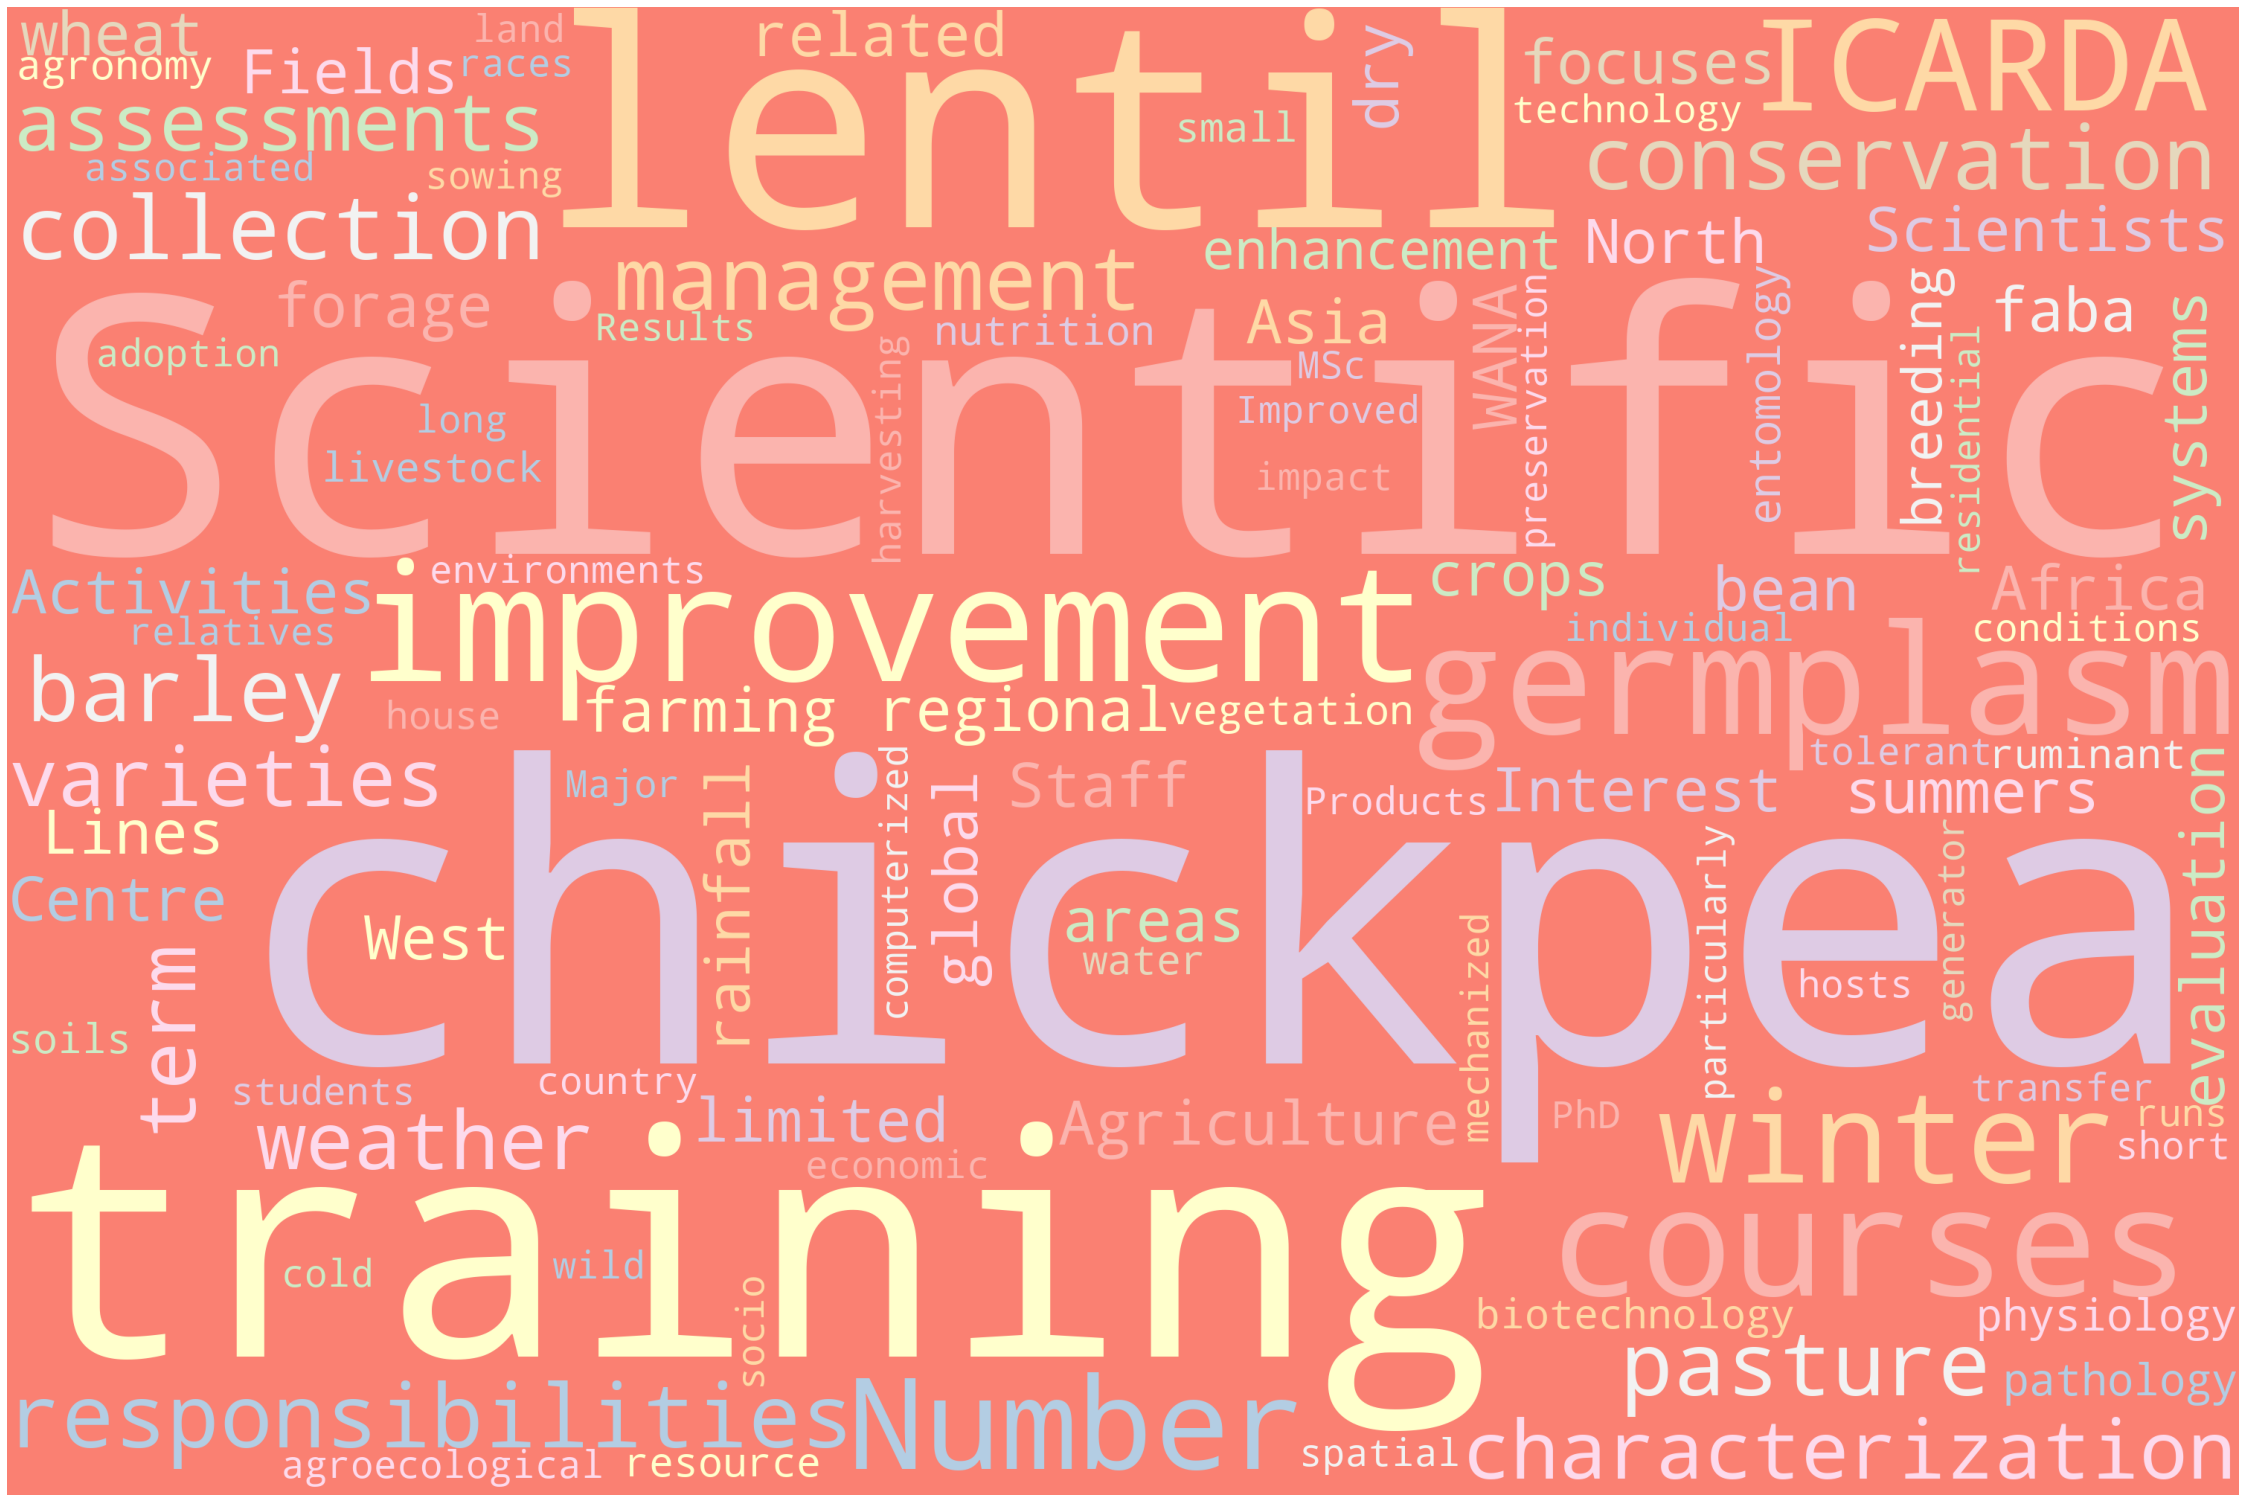

In [5]:
# Join the different processed titles together.
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
new_stop = pd.read_csv('stop_words.csv')
# lista de stop words en español
stop_words = stopwords.words('english')
stop_words.extend(new_stop['palabra'])
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, 
            background_color='salmon', colormap='Pastel1', 
            collocations=False, stopwords = stop_words).generate(data['document'][60]) ## Seleccione aqui documento del 0-68
plot_cloud(wordcloud)

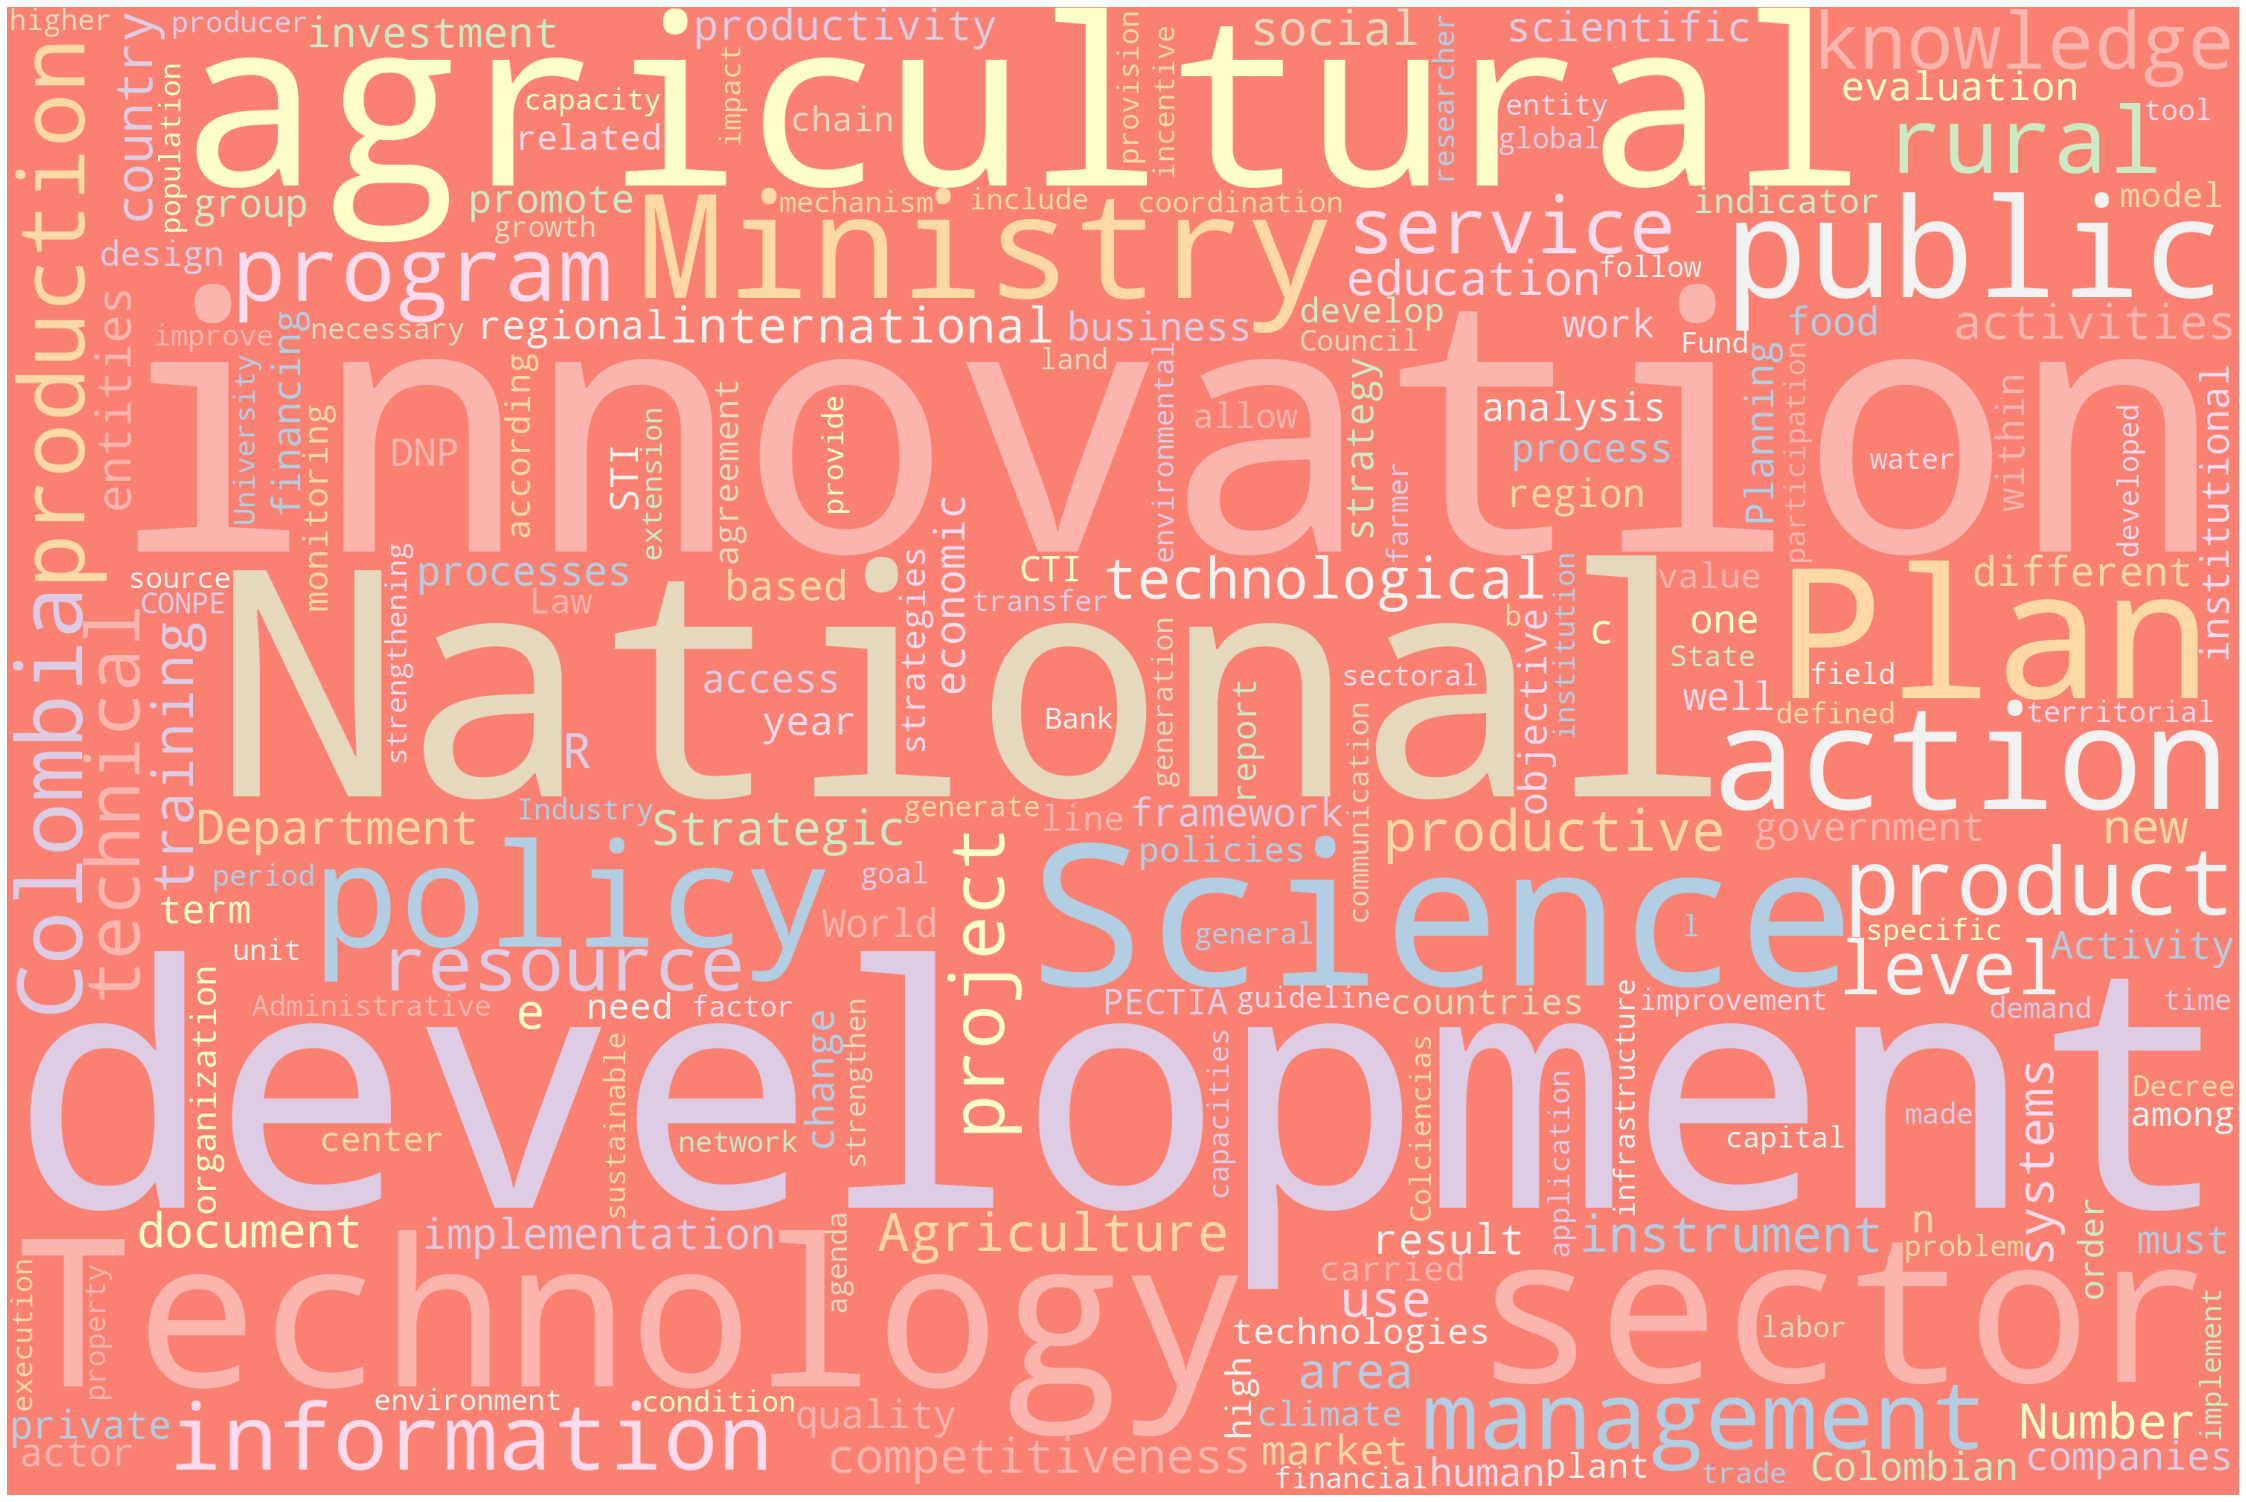

In [6]:
## Wordcloud global
textos = ",".join(list(data['document'].values))
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, 
                background_color='salmon', colormap='Pastel1', 
                collocations=False, stopwords = stop_words).generate(textos) ## Seleccione aqui documento del 0-60
plot_cloud(wordcloud)

## Iniciando con el modelo LDA
Creamos y reducimos el diccionario filtrando las palabras más raras o demasiado frecuentes. Para ello haremos uso de la función filter_extremes, que nos proporciona el objeto Dictionary y que nos servirá para mantener únicamente aquellos tokens que se encuentran en al menos 2 documentos (no_below) y los que están contenidos en no más del 80% de documentos (no_above).

In [9]:
#Creando el diccionario
dictionary = gensim.corpora.Dictionary(data['clean_text'])
print('Antes de filtrar')
print(dictionary)
dictionary.filter_extremes(no_below=5,no_above=0.8)
print('Despues de filtrar')
print(dictionary)

Antes de filtrar
Dictionary(11069 unique tokens: ['basic', 'bioeconomy', 'conpes', 'converging', 'creative']...)
Despues de filtrar
Dictionary(2459 unique tokens: ['basic', 'conpes', 'cultural', 'document', 'energy']...)


Inicializamos el corpus en base al diccionario que acabamos de crear. Cada documento se transformará en una bolsa de palabras (BOW del inglés bag-of-words) con las frecuencias de aparición.

Tras aplicar esta técnica veremos que cada documento está representado como una lista de tuplas donde el primer elemento es el identificador numérico de la palabra y el segundo es el número de veces que esa palabra aparece en el documento.

In [10]:
#Creación del corpus
corpus = [dictionary.doc2bow(text) for text in data['clean_text']]
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('basic', 1),
  ('conpes', 1),
  ('cultural', 1),
  ('document', 1),
  ('energy', 1),
  ('environment', 2),
  ('equity', 1),
  ('health', 1),
  ('human', 1),
  ('industry', 2),
  ('life', 1),
  ('resource', 1),
  ('science', 3),
  ('social', 1),
  ('space', 1),
  ('sustainable', 1),
  ('water', 1)]]

## Encontrando el numero óptimo de valores de los parámetros (k, alpha y beta)

La siguiente función es usada para encontrar el número óptimo de parámetros para el modelo,para cada modelo de calcula la perplejidad y coherencia. 

In [16]:
mallet_path = 'mallet-2.0.8/bin/mallet'
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data['clean_text'], start=2, limit=40, step=6)

2


KeyboardInterrupt: 

In [18]:
model_list

NameError: name 'model_list' is not defined

In [27]:
#Función para encontrar los parametros optimos del modelo k, alpha, beta
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data['clean_text'], dictionary=dictionary, coherence='c_v')
    per=lda_model.log_perplexity(corpus)
    return coherence_model_lda.get_coherence(),per

Si desea ampliar la busqueda cambien en las siguientes opciones el valor deseado:  

# Topics range 
min_topics = 2
max_topics = 4
step_size = 1

# Alpha parameter (minimo esta en 0.1 y máximo en 0.5,con salto de 0.1)
alpha = list(np.arange(0.1,0.5, 0.1))

# Beta parameter  (minimo esta en 0.1 y máximo en 0.5, con salto de 0.1)
beta = list(np.arange(0.2, 0.5, 0.1))

In [28]:
grid = {}

# Topics range
min_topics = 2
max_topics = 5
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.1,0.5, 0.1))

# Beta parameter
beta = list(np.arange(0.2, 0.5, 0.1))
#beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplejidad': []
                }
# iterate through number of topics
for k in topics_range:
    print(k)
# iterate through alpha values
    for a in alpha:
        print(a)
 # iterare through beta values
        for b in beta:
            print(b)
            cv = compute_coherence_values(corpus=corpus, dictionary=dictionary,k=k, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv[0])
            model_results['Perplejidad'].append(cv[1]) 

2
0.1
0.2


KeyboardInterrupt: 

In [ ]:
compute_coherence_values(corpus,dictionary,3,)

In [11]:
#Obteniendo el mejor modelo acorde con la coherencia          
Resultados=pd.DataFrame(model_results)
Resultados[Resultados['Coherence'] == Resultados['Coherence'].max()]

,Topics,Alpha,Beta,Coherence,Perplejidad
18,3,0.3,0.2,0.481389,-6.592478


In [12]:
#Obteniendo el mejor modelo acorde con la Perplejida      
Resultados=pd.DataFrame(model_results)
Resultados[Resultados['Perplejidad'] == Resultados['Perplejidad'].min()]

,Topics,Alpha,Beta,Coherence,Perplejidad
9,2,0.4,0.2,0.393819,-6.679589


In [14]:
Resultados

,Topics,Alpha,Beta,Coherence,Perplejidad
0,2,0.1,0.2,0.393819,-6.679104
1,2,0.1,0.3,0.393819,-6.664925
2,2,0.1,0.4,0.393819,-6.657141
3,2,0.2,0.2,0.393819,-6.679135
4,2,0.2,0.3,0.393819,-6.664966
5,2,0.2,0.4,0.393819,-6.657354
6,2,0.3,0.2,0.393819,-6.679372
7,2,0.3,0.3,0.393819,-6.665207
8,2,0.3,0.4,0.393819,-6.657597
9,2,0.4,0.2,0.393819,-6.679589


In [42]:
Resultados1=pd.DataFrame(model_results)
Resultados1

,Topics,Alpha,Beta,Coherence,Perplejidad
0,2,0.1,0.2,0.393819,-6.679058
1,2,0.1,0.3,0.393819,-6.664790
2,2,0.1,0.4,0.393819,-6.657232
3,2,0.2,0.2,0.393819,-6.679094
4,2,0.2,0.3,0.393819,-6.664966
...,...,...,...,...,...
79,8,0.3,0.3,0.406921,-6.574741
80,8,0.3,0.4,0.408974,-6.565556
81,8,0.4,0.2,0.414388,-6.600619
82,8,0.4,0.3,0.409990,-6.579242


## Gráfico de coherencia para valores especificos de alpha y beta

In [58]:
alpha1=0.4
beta1=0.2
Resultados2=Resultados1[(Resultados1["Alpha"]==alpha1) & (Resultados1["Beta"]==beta1)]
Resultados2

,Topics,Alpha,Beta,Coherence,Perplejidad
9,2,0.4,0.2,0.393819,-6.679589
21,3,0.4,0.2,0.481389,-6.593949
33,4,0.4,0.2,0.426203,-6.665796
45,5,0.4,0.2,0.467551,-6.589045
57,6,0.4,0.2,0.456900,-6.580312
69,7,0.4,0.2,0.466144,-6.587763
81,8,0.4,0.2,0.414388,-6.600619


In [59]:
coherence_values=Resultados2["Coherence"]

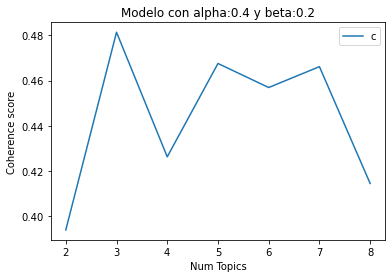

In [60]:
x = Resultados2["Topics"]
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("Modelo con alpha:" + str(alpha1) +" y beta:"+ str(beta1))
plt.show()

In [61]:
Perplejidad_values=Resultados2["Perplejidad"]

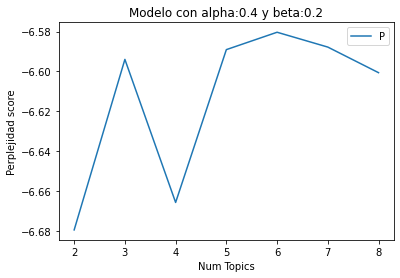

In [63]:
x = Resultados2["Topics"]
plt.plot(x, Perplejidad_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplejidad score")
plt.legend(("Perplejidad_values"), loc='best')
plt.title("Modelo con alpha:" + str(alpha1) +" y beta:"+ str(beta1))
plt.show()

In [30]:
#Modelo LDA con los parámetros seleccionados
k=3
a=0.3
b=0.2
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

KeyboardInterrupt: 

chunksize controla cuántos documentos se procesan a la vez en el algoritmo de entrenamiento. Aumentar el tamaño de los fragmentos acelerará el entrenamiento, al menos mientras el fragmento de documentos quepa fácilmente en la memoria. pass controla la frecuencia con la que entrenamos el modelo en todo el corpus (establecido en 10). Otra palabra para pases podría ser "épocas". iteraciones es algo técnico, pero esencialmente controla la frecuencia con la que repetimos un ciclo particular sobre cada documento. Es importante establecer el número de "pasos" e "iteraciones" lo suficientemente alto.

In [10]:
# Compute Perplexity del modelo seleccionado
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.926145591054316


In [11]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data['clean_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.35504393316797295


In [12]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus,dictionary)
vis

/home/wilmar3752/anaconda3/envs/nlp/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/wilmar3752/anaconda3/envs/nlp/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/wilmar3752/anaconda3/envs/nlp/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/wilmar3752/anaconda3/envs/nlp/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of impo

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.026741  0.063883       1        1  49.435639
1     -0.080130 -0.012750       2        1  26.372861
2      0.053388 -0.051134       3        1  24.191499, topic_info=              Term         Freq        Total Category  logprob  loglift
707     innovation  1874.000000  1874.000000  Default  30.0000  30.0000
1183         rural   750.000000   750.000000  Default  29.0000  29.0000
983           plan   879.000000   879.000000  Default  28.0000  28.0000
902         number   484.000000   484.000000  Default  27.0000  27.0000
12         science  1104.000000  1104.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1317        system   122.722803   521.099832   Topic3  -5.6575  -0.0268
73    agricultural   143.569044  1414.028235   Topic3  -5.5006  -0.8682
38          action   124.963459   870.671334   Topic3  -5.6394  -0.5221
859       ministry   118.171828   896.321605   Topic3  -5.6952  -0.6070
701    information   111.773349   747.329817   Topic3  -5.7509  -0.4809

[279 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2211      1  0.041700  accession
2211      2  0.041700  accession
2211      3  0.917408  accession
2212      1  0.017999     across
2212      2  0.089993     across
...     ...       ...        ...
1440      2  0.796512      woman
1440      3  0.038294      woman
2048      1  0.107488      yield
2048      2  0.107488      yield
2048      3  0.784659      yield

[549 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

El control deslizante λ permite clasificar los términos según su relevancia. De forma predeterminada, los términos de un tema se clasifican en orden decreciente según su probabilidad específica del tema ( λ = 1 ). Mover el control deslizante permite ajustar la clasificación de los términos según su grado de discriminación (o "relevancia") para el tema específico. El valor "óptimo" sugerido de λ es 0,6.

El mapa de distancia entre temas es una visualización de los temas en un espacio bidimensional.

El área de estos círculos de temas es proporcional a la cantidad de palabras que pertenecen a cada tema en el diccionario.

El gráfico de barras muestra por defecto los 30 términos más destacados. Las barras indican la frecuencia total del término en todo el corpus.

Salient es una métrica específica, definida en la parte inferior de la visualización, que se puede considerar como una métrica utilizada para identificar las palabras más informativas o útiles para identificar temas en toda la colección de textos.

## La línea a continuación nos muestra la composicióin de cada tópico y para cada uno muestra las 10 principales palabras

In [13]:
topicos = lda_model.print_topics(num_words=10, num_topics=k)
for topico in topicos:
    print(topico)

(0, '0.023*"innovation" + 0.016*"national" + 0.014*"science" + 0.012*"agricultural" + 0.011*"sector" + 0.010*"policy" + 0.008*"country" + 0.008*"knowledge" + 0.007*"technological" + 0.007*"public"')
(1, '0.013*"plan" + 0.013*"rural" + 0.011*"agricultural" + 0.011*"management" + 0.009*"information" + 0.008*"number" + 0.007*"policy" + 0.007*"entity" + 0.007*"ministry" + 0.006*"process"')
(2, '0.007*"productivity" + 0.006*"national" + 0.006*"country" + 0.006*"production" + 0.005*"program" + 0.005*"sector" + 0.005*"productive" + 0.005*"innovation" + 0.005*"colombia" + 0.005*"market"')


## Nube de palabras para cada tópico

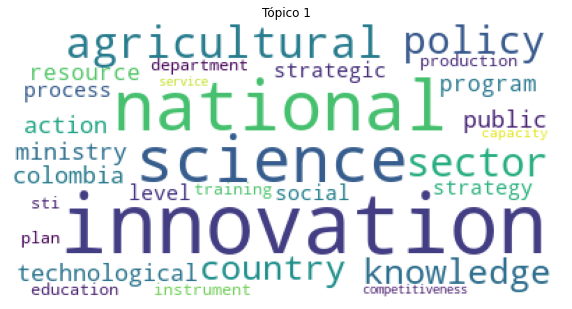

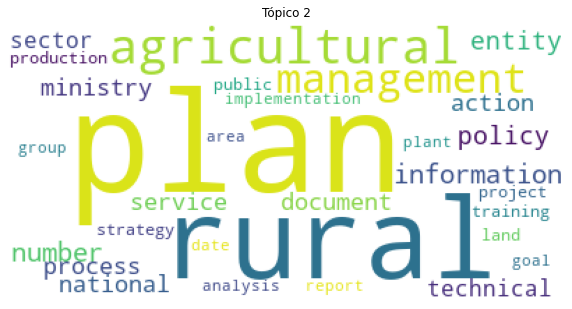

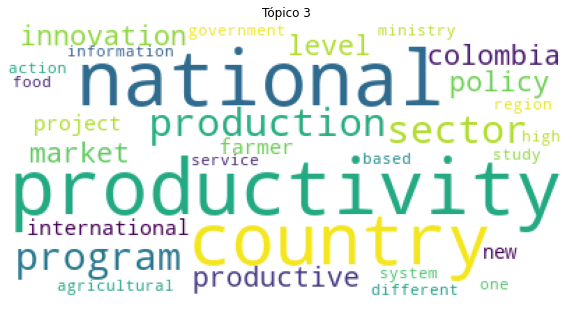

In [14]:
for i in range(0, k):
    plt.figure(figsize=(10,10))
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda_model.show_topic(i, 30))))
    plt.axis("off")
    plt.title("Tópico " + str(i+1))
    plt.show()

## Distribución de los tópicos en el documento

In [15]:
#Especifique en d el número de documento para el cual desea hacer la distribución de los tópicos
d=20
bow_noticia = corpus[d]
# Indices de los topicos mas significativos
dist_indices = [topico[0] for topico in lda_model[bow_noticia]]
# Contribución de los topicos mas significativos
dist_contrib = [topico[1] for topico in lda_model[bow_noticia]]

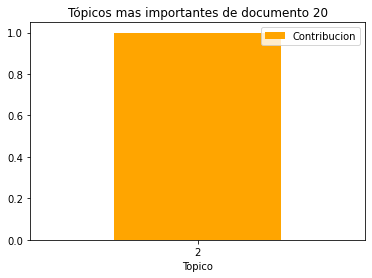

In [16]:
distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib })
distribucion_topicos.sort_values('Contribucion', 
                                 ascending=False, inplace=True)
ax = distribucion_topicos.plot.bar(y='Contribucion',x='Topico', 
                                   rot=0, color="orange",
                                   title = 'Tópicos mas importantes'
                                   ' de documento ' + str(d))

## Tópico más representativo por documento

In [17]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [18]:
df_topic_sents_keywords=format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data["file"])

/tmp/ipykernel_837/4124948175.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/tmp/ipykernel_837/4124948175.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [19]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.9682,"innovation, national, science, agricultural, s...",2021-10-20 Política CTI 2022 - 2031_VDiscusio...
1,1,0,0.5166,"innovation, national, science, agricultural, s...",3527-Competitividad-y-Productividad.pdf
2,2,0,0.9999,"innovation, national, science, agricultural, s...",4069.pdf
3,3,0,0.9824,"innovation, national, science, agricultural, s...",compes 3582.pdf
4,4,2,0.5804,"productivity, national, country, production, p...",compes 3866.pdf
5,5,0,0.9601,"innovation, national, science, agricultural, s...",CPC_INC_2020_2021_Ciencia-tecnologia.pdf
6,6,0,0.8800,"innovation, national, science, agricultural, s...",P.L.008-2017C_004-2017S (INNOVACION AGROPECUAR...
7,7,0,0.7899,"innovation, national, science, agricultural, s...",pectia-2017-actualizado.pdf
8,8,1,0.9867,"plan, rural, agricultural, management, informa...",PLAN_DE_ACCION_INSTITUCIONAL_VIGENCIA_2021.pdf
9,9,0,0.6022,"innovation, national, science, agricultural, s...",Sistemas y políticas de innovación para el sec...


## El documento más representativo de cada tópico

In [20]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

In [21]:
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

In [22]:
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

In [23]:
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9999,"innovation, national, science, agricultural, s...",4069.pdf
1,1,0.9965,"plan, rural, agricultural, management, informa...",investigacion 28.txt
2,2,0.9997,"productivity, national, country, production, p...",investigacion 20.txt


## Distribución de los tópicos en los documentos

In [24]:
# Número de documentos para cada tópico
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

In [25]:
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

1    0.5634
2    0.3239
0    0.1127
Name: Dominant_Topic, dtype: float64